In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

2025-11-25 00:53:15.679714: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-25 00:53:15.679814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-25 00:53:15.683799: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-25 00:53:15.710424: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-25 00:53:18.815318: W tensorflow/compiler/tf2

In [2]:
# Set random seeds
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
## Loading the data
dataframe = pd.read_csv("Mobile-Price-Prediction-cleaned_data.csv")
dataframe.head()

,Ratings,RAM,ROM,Mobile_Size,Primary_Cam,Selfi_Cam,Battery_Power,Price
0,4.3,4.0,128.0,6.00,48,13.0,4000,24999
1,3.4,6.0,64.0,4.50,48,12.0,4000,15999
2,4.3,4.0,4.0,4.50,64,16.0,4000,15000
3,4.4,6.0,64.0,6.40,48,15.0,3800,18999
4,4.5,6.0,128.0,6.18,35,15.0,3800,18999


In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ratings        807 non-null    float64
 1   RAM            807 non-null    float64
 2   ROM            807 non-null    float64
 3   Mobile_Size    807 non-null    float64
 4   Primary_Cam    807 non-null    int64  
 5   Selfi_Cam      807 non-null    float64
 6   Battery_Power  807 non-null    int64  
 7   Price          807 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 50.6 KB


In [5]:
dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
Ratings,807.0,4.112639,0.367830,2.8,3.9,4.10,4.4,4.8
RAM,807.0,5.941760,2.056359,0.0,6.0,6.00,6.0,12.0
ROM,807.0,64.390335,53.868626,2.0,32.0,32.00,64.0,256.0
Mobile_Size,807.0,5.620660,3.957409,2.0,4.5,4.77,6.3,44.0
Primary_Cam,807.0,47.821561,11.155916,5.0,48.0,48.00,48.0,64.0
Selfi_Cam,807.0,8.868649,4.547254,0.0,8.0,8.00,12.0,23.0
Battery_Power,807.0,3278.859975,937.628801,1020.0,3000.0,3000.00,3800.0,6000.0
Price,807.0,14269.167286,23092.739983,479.0,984.0,1699.00,18994.5,153000.0


In [6]:
# Separating predictors from targets
X = dataframe.drop("Price", axis=1)
y = dataframe["Price"]

In [7]:
## Shape of X and y
X.shape, y.shape

((807, 7), (807,))

In [8]:
# Split into train, val and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((564, 7), (243, 7), (564,), (243,))

In [9]:
## Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# For efficiency, convert data to tensors or as a tf_.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(128)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(128)

2025-11-25 00:53:23.713419: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [11]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [12]:
for batch in train_dataset:
    print(len(batch[0]))

128
128
128
128
52


In [13]:
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [14]:
input_shape = X_train.shape[1]
input_shape

7

**Functional API advantages**

- More flexible (skip connections, multi-input, multi-output)
- Cleaner naming
- Visual model graph easier to inspect

In [15]:
# Define Model using the Functional API

from tensorflow.keras import layers, Model, Input

# Functional API version
# Input Layer
inputs = Input(shape=(input_shape, ), name="input_layer")

# Hidden Layer
x = layers.Dense(128, activation="relu", name="dense_layer_one")(inputs)
x = layers.Dense(64, activation="relu", name="dense_layer_two")(x)

# Output Layer
outputs = layers.Dense(1, name="output_layer")(x)

func_model = Model(inputs=inputs, outputs=outputs, name="functional_regression_model")

In [16]:
func_model.summary()

Model: "functional_regression_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 7)]               0         
                                                                 
 dense_layer_one (Dense)     (None, 128)               1024      
                                                                 
 dense_layer_two (Dense)     (None, 64)                8256      
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 9345 (36.50 KB)
Trainable params: 9345 (36.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
## Define Optimizer, Loss and Metrics
optimizer = tf.keras.optimizers.Adam(1e-3)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer

### Compile Model

In [18]:
func_model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=["mse"]
)

### Fitting the model

In [19]:
EPOCHS = 1000

history = func_model.fit(train_dataset,
         validation_data=val_dataset,
         epochs=EPOCHS)

Epoch 1/1000
5/5 [==============================] - 3s 118ms/step - loss: 693166144.0000 - mse: 693166144.0000 - val_loss: 836128512.0000 - val_mse: 836128512.0000
Epoch 2/1000
5/5 [==============================] - 0s 17ms/step - loss: 693153152.0000 - mse: 693153152.0000 - val_loss: 836112832.0000 - val_mse: 836112832.0000
Epoch 3/1000
5/5 [==============================] - 0s 15ms/step - loss: 693138944.0000 - mse: 693138944.0000 - val_loss: 836094912.0000 - val_mse: 836094912.0000
Epoch 4/1000
5/5 [==============================] - 0s 15ms/step - loss: 693122688.0000 - mse: 693122688.0000 - val_loss: 836074048.0000 - val_mse: 836074048.0000
Epoch 5/1000
5/5 [==============================] - 0s 15ms/step - loss: 693103168.0000 - mse: 693103168.0000 - val_loss: 836048000.0000 - val_mse: 836048000.0000
Epoch 6/1000
5/5 [==============================] - 0s 15ms/step - loss: 693078656.0000 - mse: 693078656.0000 - val_loss: 836014848.0000 - val_mse: 836014848.0000
Epoch 7/1000
5/5 [===

### Making Predictions

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$


In [20]:
## Evaluation after training
y_pred = func_model.predict(X_test)

# Calculate MAE or MSE manually
mse = tf.keras.metrics.mean_squared_error(y_test, y_pred).numpy().mean()
mae = tf.keras.metrics.mean_absolute_error(y_test, y_pred).numpy().mean()

print("Test MSE:", mse)
print("Test MAE:", mae)

8/8 [==============================] - 0s 4ms/step
Test MSE: 1016244350.0
Test MAE: 20819.068


In [21]:
from sklearn.metrics import r2_score

score = r2_score(y_test, y_pred)
score

0.5220667749392034

In [22]:
0.5220667749392034

0.5220667749392034

In [23]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

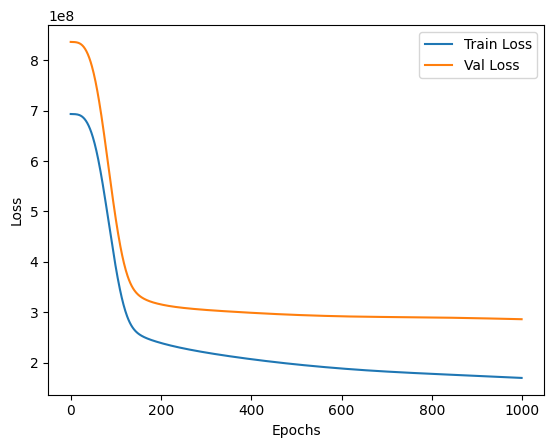

In [24]:
# Visualizing the History

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


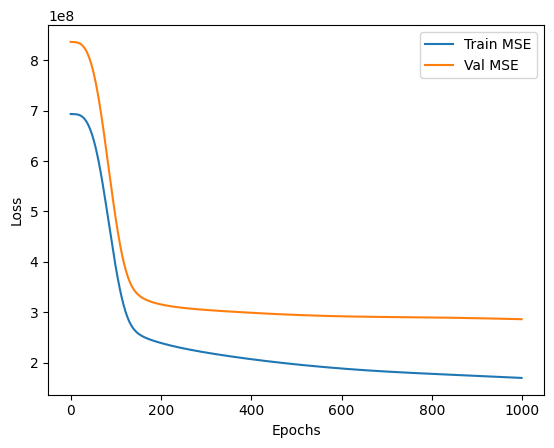

In [25]:
# Visualizing the History

plt.plot(history.history["mse"], label="Train MSE")
plt.plot(history.history["val_mse"], label="Val MSE")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
